In [1]:
!pip install langgraph langsmith langchain langchain_groq langchain_community

In [2]:
from typing import Annotated
from typing_extensions import TypedDict

In [3]:
!pip install arxiv wikipedia

In [4]:
## Working with Tools

from langchain_community.utilities import ArxivAPIWrapper, WikipediaAPIWrapper
from langchain_community.tools import ArxivQueryRun, WikipediaQueryRun

## Arxiv And Wikipedia tools
arxiv_wrapper = ArxivAPIWrapper(top_k_results=1, doc_content_chars_max=300)
arxiv_tools = ArxivQueryRun(api_wrapper=arxiv_wrapper)

api_wrapper = WikipediaAPIWrapper(top_k_resuls=1, doc_content_chars_max=300)
wiki_tools = WikipediaQueryRun(api_wrapper=api_wrapper)

In [5]:
wiki_tools.invoke("who is Sharukh Khan")

'Page: Shah Rukh Khan\nSummary: Shah Rukh Khan (pronounced [ˈʃaːɦɾʊx xäːn] ; born 2 November 1965), also known by the initialism SRK, is an Indian actor and film producer who works in Hindi cinema. Referred to in the media as the "Baadshah of Bollywood" and "King Khan", he has appeared in more than 10'

In [6]:
wiki_tools.invoke("who is president of sri lanka")

'Page: President of Sri Lanka\nSummary: The president of Sri Lanka (Sinhala: ශ්\u200dරී ලංකා ජනාධිපති Śrī Laṅkā Janādhipati; Tamil: இலங்கை ஜனாதிபதி Ilaṇkai janātipati) is the head of state and head of government of the Democratic Socialist Republic of Sri Lanka. The president is the chief executive of the '

In [7]:
arxiv_tools.invoke("Attention is all you need")

"Published: 2024-07-22\nTitle: Attention Is All You Need But You Don't Need All Of It For Inference of Large Language Models\nAuthors: Georgy Tyukin, Gbetondji J-S Dovonon, Jean Kaddour, Pasquale Minervini\nSummary: The inference demand for LLMs has skyrocketed in recent months, and serving\nmodels with "

In [10]:
tools = [wiki_tools]

## Langgraph Application

In [11]:
from langgraph.graph.message import add_messages
class State(TypedDict):
    messages:Annotated[list, add_messages]

In [12]:
from langgraph.graph import StateGraph, START, END

In [13]:
graph_builder = StateGraph(State)

In [14]:
from langchain_groq import ChatGroq

In [15]:
import os
from dotenv import load_dotenv

# Load environment variables
load_dotenv()

# Retrieve API key
groq_api_key = os.getenv("GROQ_API_KEY")

In [21]:
llm = ChatGroq(groq_api_key = groq_api_key, model_name = "Gemma2-9b-It")
llm

ChatGroq(client=<groq.resources.chat.completions.Completions object at 0x0000027527E8F580>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x0000027527E98AC0>, model_name='Gemma2-9b-It', model_kwargs={}, groq_api_key=SecretStr('**********'))

In [22]:
llm_with_tools = llm.bind_tools(tools = tools)

In [23]:
def chatbot(state:State):
    return{"messages":[llm_with_tools.invoke(state["messages"])]}

In [25]:
from langgraph.prebuilt import ToolNode, tools_condition

In [27]:
graph_builder.add_node("chatbot",chatbot)
graph_builder.add_edge(START, "chatbot")
tool_node = ToolNode(tools = tools)
graph_builder.add_node("tools", tool_node)

graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition
)

graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge("chatbot", END)

In [28]:
graph = graph_builder.compile()

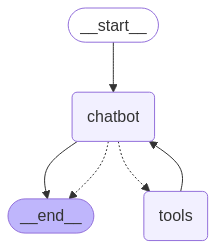

In [29]:
from IPython.display import Image, display
try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    pass

In [38]:
user_input = "Who is president of Sri Lanka?"

events = graph.stream(
    {"messages": [("user", user_input)]}, stream_mode = "values"
)

for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Who is president of Sri Lanka?
================================== Ai Message ==================================
Tool Calls:
  wikipedia (call_egz1)
 Call ID: call_egz1
  Args:
    query: President of Sri Lanka
================================= Tool Message =================================
Name: wikipedia

Page: President of Sri Lanka
Summary: The president of Sri Lanka (Sinhala: ශ්‍රී ලංකා ජනාධිපති Śrī Laṅkā Janādhipati; Tamil: இலங்கை ஜனாதிபதி Ilaṇkai janātipati) is the head of state and head of government of the Democratic Socialist Republic of Sri Lanka. The president is the chief executive of the 
================================== Ai Message ==================================

Ranil Wickremesinghe


In [39]:
user_input = "what is RLHF."

# The config is the **second positional argument** to stream() or invoke()!
events = graph.stream(
    {"messages": [("user", user_input)]},stream_mode="values"
)
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

what is RLHF.
================================== Ai Message ==================================
Tool Calls:
  wikipedia (call_makf)
 Call ID: call_makf
  Args:
    query: RLHF
================================= Tool Message =================================
Name: wikipedia

Page: Reinforcement learning from human feedback
Summary: In machine learning, reinforcement learning from human feedback (RLHF) is a technique to align an intelligent agent with human preferences. It involves training a reward model to represent preferences, which can then be used to train other mo
================================== Ai Message ==================================

Reinforcement learning from human feedback (RLHF) is a technique to align an intelligent agent with human preferences. It involves training a reward model to represent preferences, which can then be used to train other models to perform tasks in a way that is mo